In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


# Imprting the libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import random
import math
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim import lr_scheduler, Adam, SGD

import torch.nn.functional as F
from torch.autograd import Variable

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import os
import copy

# Importing the Data

In [3]:
train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing the Raw Data
As the Data is having 785 columns which have m 28*28*1 images and their labels.
We are converting the data in aproper format to feed them in the model.

In [5]:
#Getting the label column
train_labels = np.array(train['label'])
# m = No of Exaples
m_train = train.shape[0] #m in training data
m_test = test.shape[0]  #m in testing data
#reshaping the long 1D vector of shape 1*784 into a 3D vector of shape 1*28*28 
train_data = np.array(train.loc[:,'pixel0':]).reshape(m_train,1,28,28)
test_data = np.array(test.loc[:,'pixel0':]).reshape(m_test,1,28,28)

# Visualising the Data

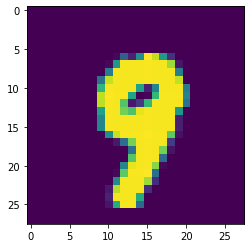

The label for the above image is 9


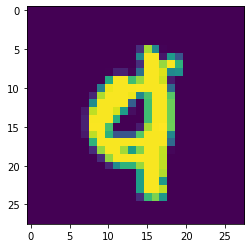

The label for the above image is 9


In [6]:
k = 0
while k<2:
    i = random.randint(0,42000)
    plt.imshow(train_data[i,0,:,:])
    plt.show()
    print(f"The label for the above image is {train_labels[i]}")
    k+=1

### Splitting the data into Training, Validation and Testing Set
We are using 90% data for training, 5% for Validation and 5% for Testing purpose.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((33600, 1, 28, 28), (4200, 1, 28, 28), (4200, 1, 28, 28))

### Transformer
 Making a Transformer to convert our data into the PyTorch Tensors and Normalize the data.
 We are converting the data with Mean = 0.5 and STD = 0.5 across the channel

In [9]:
# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### Dataset

In [10]:
class DigitDataset(Dataset):

    def __init__(self,images,labels,transfrom = transform):
        # Initialize data, download, etc.
        self.x_data = torch.from_numpy(images/255.) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(labels) # size [n_samples, 1]
        self.n_samples = images.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [11]:
train_dataset = DigitDataset(X_train,y_train)
val_dataset = DigitDataset(X_val,y_val)
test_dataset = DigitDataset(X_test,y_test)

### Creating Dataloaders
We will use Batch-Size = 64

In [12]:
batch_size=64
# defining trainloader, valloader and testloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

##### Visualising the Data-loaders

torch.Size([64, 1, 28, 28])
torch.Size([64])


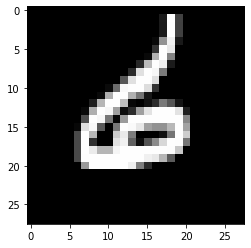

In [13]:
# shape of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

torch.Size([64, 1, 28, 28])
torch.Size([64])


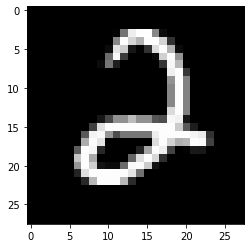

In [14]:
# shape of validation data
dataiter = iter(val_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [15]:
#Checking the device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

I am using GPU to train the model hence everything is sent to GPU via *.cuda()* command

# Model Building
Our Model is taking 1*28*28 Images as input and having the output with dimension = 10

In [16]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, 10)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

Defining the Optimizer, Criterion (loss function) and Learning Rate Scheduler.

In [17]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


## Training of the model

In [18]:
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['val'] = len(val_dataset)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time() #Return the time in seconds since the epoch as a floating point number

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataloaders = {}
    dataloaders['train'] = train_loader
    dataloaders['val'] = val_loader
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:

model = model.to(device)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2280 Acc: 0.9289
val Loss: 0.1374 Acc: 0.9545

Epoch 1/49
----------
train Loss: 0.1135 Acc: 0.9631
val Loss: 0.1206 Acc: 0.9631

Epoch 2/49
----------
train Loss: 0.0939 Acc: 0.9704
val Loss: 0.1113 Acc: 0.9648

Epoch 3/49
----------
train Loss: 0.0865 Acc: 0.9726
val Loss: 0.1091 Acc: 0.9679

Epoch 4/49
----------
train Loss: 0.0804 Acc: 0.9746
val Loss: 0.0980 Acc: 0.9702

Epoch 5/49
----------
train Loss: 0.0765 Acc: 0.9762
val Loss: 0.0942 Acc: 0.9707

Epoch 6/49
----------
train Loss: 0.0729 Acc: 0.9768
val Loss: 0.0980 Acc: 0.9698

Epoch 7/49
----------
train Loss: 0.0514 Acc: 0.9836
val Loss: 0.0813 Acc: 0.9755

Epoch 8/49
----------
train Loss: 0.0473 Acc: 0.9851
val Loss: 0.0822 Acc: 0.9750

Epoch 9/49
----------
train Loss: 0.0463 Acc: 0.9848
val Loss: 0.0854 Acc: 0.9745

Epoch 10/49
----------
train Loss: 0.0446 Acc: 0.9856
val Loss: 0.0851 Acc: 0.9733

Epoch 11/49
----------
train Loss: 0.0445 Acc: 0.9860
val Loss: 0.0850 Acc: 0.9748

Ep

### Testing our model on test-data

In [21]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    images = images.cuda()
    images = images.type(torch.cuda.FloatTensor)
    labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 4200

Model Accuracy = 0.9776190476190476


### Predicting for unlabelled Data

In [22]:
test = test_data/255 #Normalizing the data
test = torch.from_numpy(test)  # Converting into Tensors
test = test.type(torch.cuda.FloatTensor) 

In [23]:
with torch.no_grad():
  outputs = model(test.cuda())

Outputs are the output of the final linear Layer having shape = 10

In [24]:
ps = torch.exp(outputs)

#max_value is the value of highest no. in each 10-dim vector 
#index is the index of that max value 
max_value, index = torch.max(ps,axis=1) 

index = index.cpu()
#Converting Prediction to numpy for Submission
prediction = index.numpy()

print(prediction.shape)
print(prediction[:5])

(28000,)
[2 0 9 0 3]


### Saving the Prediction in the acceptable format 

In [25]:
k = np.arange(1,28001)
submission = pd.DataFrame({
        "ImageId":k ,
        "Label": prediction

    })

submission.to_csv('Digit_Recognition_submission.csv', index=False)